# Continuous interactions

In pursuit of clarifying the construction and interpretation of CONTINUOUS INTERACTIONS among two or more continous predictor variables, in this section I develop a simple regression example and show you a way to plot the two way interaction between two continous variables. The method is a thrypich plot, a panel of three complimentary figures that comprise a whole picture of regression results.

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from scipy import stats

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.information_criterion"] = "waic"  # set information criterion to use in `compare`
az.rcParams["stats.ic_scale"] = "deviance"  # set information criterion scale
np.random.seed(0)

In [5]:
d = pd.read_csv("tulips.csv", delimiter=";")
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


The blooms column will be our outcome - what we wish to predict. The water and shafe columns will be out predictor variables. Since both light and water help plants grow and produce blooms, it stands to reason that the independent effect of each will be to produce bigger blooms. But we'll also be interested in the interaction between these two variables. In the abses of light, for example, its hard to see how water will help a plant. Likewise in the absence of water, sunlight does a plant little good.

In the absence of a good mechanistic model of the interaction, one that uses a theory of the plants physiology to hypothesise the functional relationship between light and water, then a simple linear two-way interaction is a good start, but ultimately its not close to the bet we can do.


### The models

We are going to study two models. 

- The model with both water and shade, but without the interaction
- the model that also contains the interaction term.

To make interaction easier, lets centre W and S by scale B by its maximum

In [6]:
d["blooms_std"] = d["blooms"] / d["blooms"].max()
d["water_cent"] = d["water"] - d["water"].mean()
d["shade_cent"] = d["shade"] - d["shade"].mean()

I’ve scaled blooms by its maximum observed value, for three reasons. First, the large values on the raw scale will make optimization difficult. Second, it will be easier to assign a reasonable prior this way. Third, we don’t want to standardize blooms, because zero is a meaningful boundary we want to preserve.

## Priors

The goal is to assign weakly informative priors that discourage overfitting

In [7]:
with pm.Model() as m_8_4:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)

    mu = a + bw * d["water_cent"] + bs * d["shade_cent"]
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"])

    m_8_4_trace = pm.sample()
    m_8_4_post = pm.sample_posterior_predictive(m_8_4_trace, var_names=["a", "bw", "bs"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bs, bw, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1144.41draws/s]
The acceptance probability does not match the target. It is 0.8865290296340907, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:00<00:00, 26700.86it/s]


next model - interactions

To build an interaction between water and shade, we need to construct mu so that the impact of changing either water or shade depends upon the value of the other variable. For example, if water is low, then decreasing the shade cant help as much as when water is high. So we want the slope of water Bw to be conditional on shade. Likewise for shade being conditional on water. How do we do this?

In the previous example, terrain ruggedness, we made a slope conditional on the value of a category. When there are in principle an infinite number of categories, then its harder. In this case the 'categories' of shade and water are, in principle, infinite and ordered. We only observed three levels of water, but the model should be able to make a prediction with a water level intermediate between any of the two observed ones. With continous interactions, the problem isnt so much the infinite part but rather the ordered part. Even if we only cared about the three observed values, we still need to preserve the ordering, which is bigger than which. So what to do?

The conventional answer is to reapply the original geocentrism that justifies a linear regression. Whe we have two variables, an outcome and a predictor, and we wish to model the mean and the outcome such that it is conditional on the value of a continuous predictor x, we can use a linear model. Now in order to make the slope beta conditional on yet another variable we can just recursively apply the same trick.

In [8]:
with pm.Model() as m_8_5:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)
    bws = pm.Normal("bws", 0, 0.25)

    mu = a + bw * d["water_cent"] + bs * d["shade_cent"] + bws * d["water_cent"] * d["shade_cent"]
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"])

    m_8_5_trace = pm.sample()
    m_8_5_post = pm.sample_posterior_predictive(m_8_5_trace, var_names=["a", "bw", "bs", "bws"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bws, bs, bw, a]
100%|██████████| 2000/2000 [00:00<00:00, 28689.01it/s]


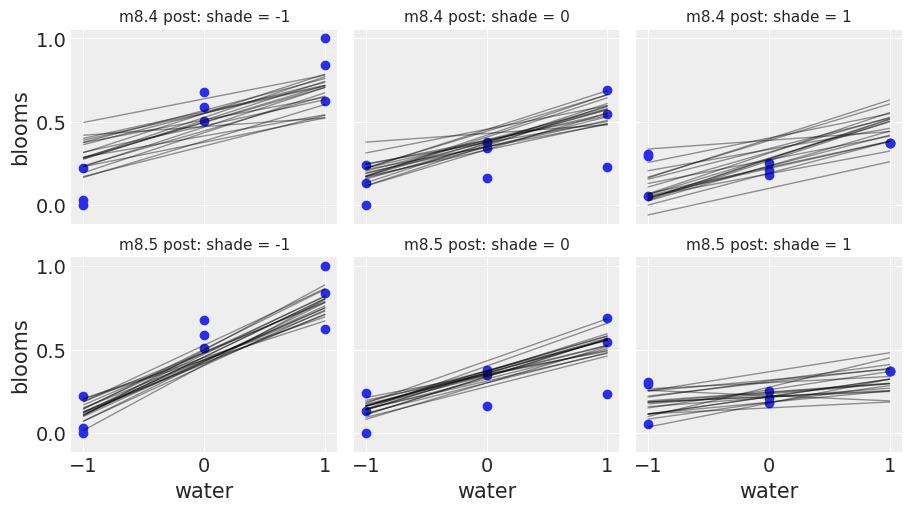

In [9]:
_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    ind = d.shade_cent == shade
    for ax in axs[:, i]:
        ax.scatter(d.loc[ind, "water_cent"], d.loc[ind, "blooms_std"])
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"m8.4 post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_4_post["a"][:n_lines]
        + m_8_4_post["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + m_8_4_post["bs"][:n_lines] * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"m8.5 post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_5_post["a"][:n_lines]
        + m_8_5_post["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + m_8_5_post["bs"][:n_lines] * shade
        + m_8_5_post["bws"][:n_lines] * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

for ax in axs.flat:
    if ax.is_first_col():
        ax.set_ylabel("blooms")
    if ax.is_last_row():
        ax.set_xlabel("water");

The result of the interaction is on the bottom, with the non-interaction (main effects) model at the top. Notice that the top model believes that water helps - there is a positive slope in each plot - and that shade hurts - the lines sink lower moving from left to right. But the slope with water doesnt change across shade levels. Without the interaction, it cannot vary. In the bottom row, the interaction is turned on. Now the model believes that the effect of water decreases as shade increases. The lines get flat